In [2]:
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='browser'
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import scipy as sp
import scipy.cluster

In [3]:
density_data = pd.read_csv("../Curated_data/cluster_0_data.csv", low_memory=False)

In [4]:
mineral = 'Density_gcm3'
filter = ['Sulph1_Code', 'Sulph1_Pct', 'Sulph2_Code', 'Sulph2_Pct']
deposit_data = density_data

deposit_data = deposit_data.dropna(subset=[mineral] + filter)
df1 = deposit_data
variable = mineral

In [5]:
two_composite_1covariates = deposit_data

missing_percentage = (two_composite_1covariates.isnull().sum() / len(two_composite_1covariates)) * 100

variables_to_remove = missing_percentage[missing_percentage > 5].index

two_composite_1covariates = two_composite_1covariates.drop(columns=variables_to_remove)


encoded_data = two_composite_1covariates.copy()

threshold = 10

for column in two_composite_1covariates.columns:
    if two_composite_1covariates[column].dtype == 'object':
        unique_values = two_composite_1covariates[column].nunique()
        
        if unique_values <= threshold:
            # Perform one-hot encoding for columns with unique values within the threshold
            encoded_columns = pd.get_dummies(encoded_data[column], prefix=column)
            encoded_columns = encoded_columns.astype(int)  # Convert to integers (0 or 1)
            encoded_data = pd.concat([encoded_data, encoded_columns], axis=1)
            encoded_data = encoded_data.drop(columns=[column])




encoded_columns = [col for col in encoded_data.columns if '_Code_' in col]

total_columns = []

for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column and sum them
    encoded_data[total_column] = (
        encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    )

# List to store the total columns
total_columns = []

# Initialize a dictionary to accumulate totals for each category
category_totals = {}

# Iterate through the encoded columns and calculate the total for each category
for col in encoded_columns:
    # Extract the prefix and original column name
    prefix, original_column = col.split('_Code_')
    
    # Calculate the total for the category
    total_column = f"{original_column}_Total"
    if total_column not in total_columns:
        total_columns.append(total_column)
    
    # Multiply the code column by the corresponding percentage column
    total_values = encoded_data[f"{prefix}_Code_{original_column}"] * encoded_data[f"{prefix}_Pct"]
    
    # Accumulate the totals for each category
    if total_column in category_totals:
        category_totals[total_column] += total_values
    else:
        category_totals[total_column] = total_values

# Add accumulated totals to the DataFrame
for total_column, total_values in category_totals.items():
    encoded_data[total_column] = total_values


In [6]:
variable_names = ['Sc_ppm',
 'Al_pct',
 'Y_ppm',
 'V_ppm',
 'Sr_ppm',
 'Ca_pct',
 'P_ppm',
 'Si_pct',
 'Li_ppm',
 'Mg_pct',
 'La_ppm',
 'RQD_Pct',
 'Alt1_Int_wk',
 'Ba_ppm',
 'Sulph1_Code_PO',
 'IP_pct',
 'Sulph2_Code_CP',
 'Sulph2_Code_PO',
 'X',
 'PY_Total',
 'Z',
 'PO_Total',
 'CP_Total',
 'Cr_ppm',
 'B_ppm',
 'Y',
 'Sb_ppm',
 'Weathering']

In [7]:
filtered_encoded_data = encoded_data[encoded_data.columns.intersection(variable_names+ ['Density_gcm3', 'Name'])]

deposit_data = encoded_data[['Name', 'X', 'Y', 'Z', 'Density_gcm3', 'RQD_Pct', 'Cr_ppm', 'CP_Total',
       'PO_Total', 'PY_Total']]
total_columns = ['CP_Total','PO_Total', 'PY_Total']


deposit_data.describe()
deposit_data.fillna(0, inplace=True)
deposit_data

C:\Users\23478671\AppData\Local\Temp\ipykernel_26872\1885046316.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Name,X,Y,Z,Density_gcm3,RQD_Pct,Cr_ppm,CP_Total,PO_Total,PY_Total
393,KV-NME001,3498922.13,7511747.51,148.80,3.13,88.00,212.6,1.0,1.0,0.0
394,KV-NME001,3498922.68,7511747.45,146.88,3.15,88.00,268.0,1.0,1.0,0.0
434,KV-NME001,3498945.16,7511745.25,70.14,3.22,99.00,215.0,1.0,1.0,0.0
435,KV-NME001,3498945.73,7511745.20,68.22,3.22,99.00,236.0,1.5,2.0,0.0
436,KV-NME001,3498946.29,7511745.15,66.30,3.22,99.00,256.0,2.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...
81071,KV365,3499347.52,7510618.17,85.03,3.44,92.35,131.0,0.2,3.0,0.0
81072,KV365,3499347.32,7510617.19,83.30,3.43,92.35,125.0,0.2,3.0,0.0
81073,KV365,3499347.13,7510616.22,81.56,3.44,85.84,128.0,0.2,3.0,0.0
81074,KV365,3499346.93,7510615.24,79.83,3.40,85.84,129.0,0.2,3.0,0.0


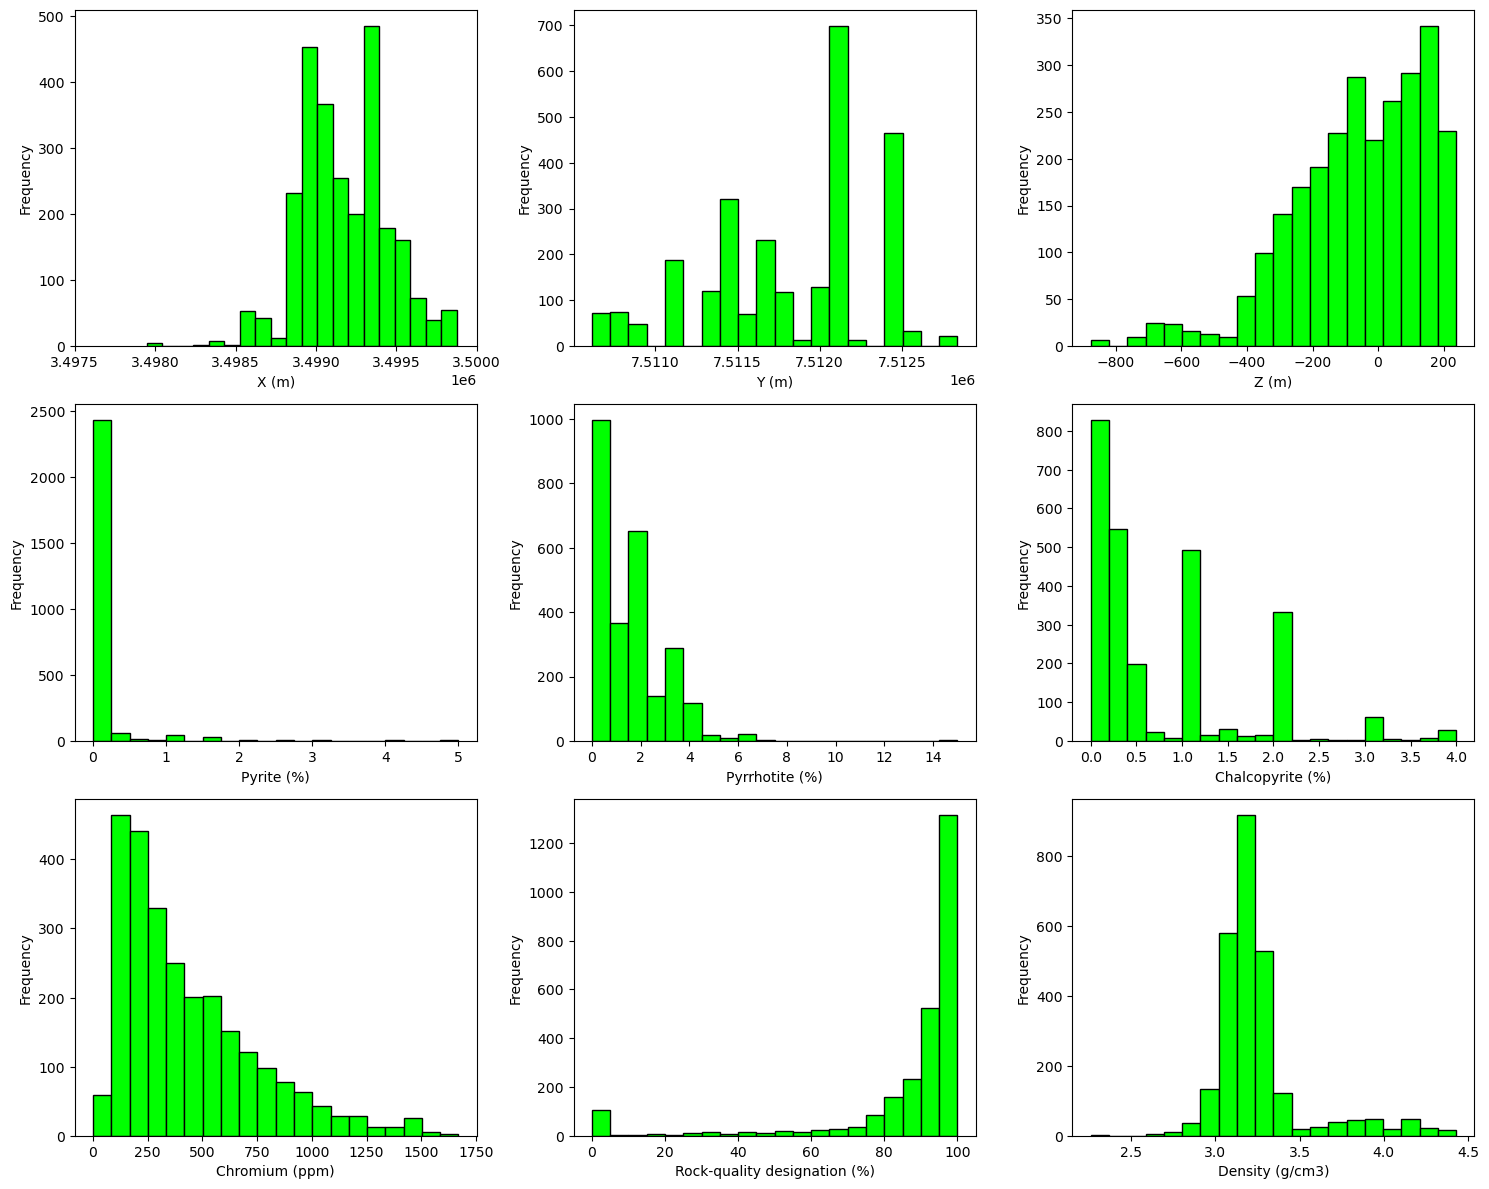

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset

# List of variables
variables = ['X', 'Y', 'Z', 'PY_Total', 'PO_Total', 'CP_Total', 'Cr_ppm', 'RQD_Pct', 'Density_gcm3']

variables2 = ['X (m)', 'Y (m)', 'Z (m)', 'Pyrite (%)', 'Pyrrhotite (%)', 'Chalcopyrite (%)', 'Chromium (ppm)', 'Rock-quality designation (%)', 'Density (g/cm3)']
# Create subplots
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))

# Plot histograms for each variable
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    axs[row, col].hist(deposit_data[var], bins=20, color='#00FF00', edgecolor='black')
    # axs[row, col].set_title('Histogram of ' + var)
    axs[row, col].set_xlabel(str(variables2[i]))
    axs[row, col].set_ylabel('Frequency')
    axs[row, col].grid(False)
    if var == 'X':
        x_ticks = axs[row, col].get_xticks()
        x_ticks = x_ticks[::1]  # Select every 3rd tick
        axs[row, col].set_xticks(x_ticks)

plt.tight_layout()
plt.show()


In [18]:
# Scale X,Y,Z using the same scale 
columns_to_normalize = ['X', 'Y', 'Z']   

min_values = deposit_data[columns_to_normalize].min()

for column in columns_to_normalize:
    deposit_data[column] = deposit_data[column] - min_values[column]

# Calculate the minimum and maximum values from all three variables
min_values = deposit_data[columns_to_normalize].min().min()
max_values = deposit_data[columns_to_normalize].max().max()

# Scale the data to (0, 1) using the calculated minimum and maximum values
for column in columns_to_normalize:
    deposit_data[column] = (deposit_data[column] - min_values) / (max_values - min_values)

#Scale the rest of the covariates in their own scale
covariates = ['CP_Total','PO_Total', 'PY_Total','RQD_Pct', 'Cr_ppm' ]
scaler = MinMaxScaler()
deposit_data.loc[:, [mineral] +covariates] = scaler.fit_transform(deposit_data.loc[:,[mineral] + covariates])


C:\Users\23478671\AppData\Local\Temp\ipykernel_26872\3257975698.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_26872\3257975698.py:15: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\23478671\AppData\Local\Temp\ipykernel_26872\3257975698.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [20]:
deposit_data.to_csv('filtered_deposit_data.csv', index=False)
